# Environment Preparation

## Imports


In [137]:
#data extraction
from sqlalchemy          import create_engine
from sqlalchemy_utils    import database_exists, create_database
from postgre_credentials import *

#plot and handle
import pandas            as pd
import numpy             as np
import seaborn           as sns
import scikitplot        as skplt
import matplotlib.pyplot as plt
import pickle

#display
import sweetviz                   as sv
from tabulate                 import tabulate
from IPython.core.display     import HTML
from IPython.display          import Image

#preparation
from sklearn import ensemble        as en
from sklearn import model_selection as ms
from sklearn import preprocessing   as pp

## Path Handlers

In [138]:
datapath = '../data/'
imagepath = '../images/'
reportpath = '../reports/'
featurepath = '../src/features/'

## Helper Functions

In [139]:
def jupyter_settings():
    """ Optimize general settings, standardize plot sizes, etc. """
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [12, 6]
    plt.rcParams['font.size'] = 20
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    pd.set_option('display.max_columns', 30)
    pd.set_option('display.max_rows', 30)
jupyter_settings()

def psycopg_connect():
    """"" Creates a psycopg connection from file postgre_credentials """""
    conn = pg.connect(    user = pg_user,
                          password = pg_passwd,
                          host = pg_host,
                          port = pg_port,
                          database = pg_db)
    return conn

# Data Collection


Lib sqlalchemy will be used.

In [141]:
# load from file postgre_credentials
url = 'postgresql://'+pg_user+':'+pg_passwd+'@'+pg_host+':'+pg_port+'/'+pg_db+''

if not database_exists(url):
    #create_database(url)
    print ("database does not exist!")
engine = create_engine(url, pool_size=50, echo=False)

In [143]:
#connected:
#engine.url

In [144]:
#select distinct schemas
query = "SELECT distinct(table_schema) from information_schema.tables"
df = pd.read_sql( query, engine )
df.head(10)

,table_schema
0,public
1,pg_catalog
2,information_schema
3,pa004


In [145]:
#select tables from schema
query = "SELECT * FROM information_schema.tables WHERE table_schema = 'pa004'"
df = pd.read_sql( query, engine )
df.head(10)

,table_catalog,table_schema,table_name,table_type,self_referencing_column_name,reference_generation,user_defined_type_catalog,user_defined_type_schema,user_defined_type_name,is_insertable_into,is_typed,commit_action
0,comunidadedsdb,pa004,users,BASE TABLE,None,None,None,None,None,YES,NO,None
1,comunidadedsdb,pa004,vehicle,BASE TABLE,None,None,None,None,None,YES,NO,None
2,comunidadedsdb,pa004,insurance,BASE TABLE,None,None,None,None,None,YES,NO,None


In [146]:
query = """SELECT * FROM pa004.insurance """
df = pd.read_sql( query, engine )
df.head()

,id,previously_insured,annual_premium,vintage,response
0,1,0,40454.0,217,1
1,2,0,33536.0,183,0
2,3,0,38294.0,27,1
3,4,1,28619.0,203,0
4,5,1,27496.0,39,0


In [147]:
query = """SELECT * FROM pa004.vehicle """
df = pd.read_sql( query, engine )
df.head()

,id,driving_license,vehicle_age,vehicle_damage
0,1,1,> 2 Years,Yes
1,2,1,1-2 Year,No
2,3,1,> 2 Years,Yes
3,4,1,< 1 Year,No
4,5,1,< 1 Year,No


In [148]:
query = """SELECT * FROM pa004.insurance """
df = pd.read_sql( query, engine )
df.head()

,id,previously_insured,annual_premium,vintage,response
0,1,0,40454.0,217,1
1,2,0,33536.0,183,0
2,3,0,38294.0,27,1
3,4,1,28619.0,203,0
4,5,1,27496.0,39,0


In [149]:
#build raw dataset:
query = """
SELECT *
FROM pa004.users u 
INNER JOIN pa004.vehicle v on u.id = v.id 
INNER JOIN pa004.insurance i ON u.id = i.id
ORDER BY u.id
"""
df = pd.read_sql( query, engine )
df.head()

,id,gender,age,region_code,policy_sales_channel,id,driving_license,vehicle_age,vehicle_damage,id,previously_insured,annual_premium,vintage,response
0,1,Male,44,28.0,26.0,1,1,> 2 Years,Yes,1,0,40454.0,217,1
1,2,Male,76,3.0,26.0,2,1,1-2 Year,No,2,0,33536.0,183,0
2,3,Male,47,28.0,26.0,3,1,> 2 Years,Yes,3,0,38294.0,27,1
3,4,Male,21,11.0,152.0,4,1,< 1 Year,No,4,1,28619.0,203,0
4,5,Female,29,41.0,152.0,5,1,< 1 Year,No,5,1,27496.0,39,0


In [150]:
# remove duplicate columns (i.e. the 'id' from vehicle and insurance tables)
df_raw = pd.read_sql( query, engine )
df_raw = df_raw.loc[:,~df_raw.columns.duplicated()]
df_raw.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,1,Male,44,28.0,26.0,1,> 2 Years,Yes,0,40454.0,217,1
1,2,Male,76,3.0,26.0,1,1-2 Year,No,0,33536.0,183,0
2,3,Male,47,28.0,26.0,1,> 2 Years,Yes,0,38294.0,27,1
3,4,Male,21,11.0,152.0,1,< 1 Year,No,1,28619.0,203,0
4,5,Female,29,41.0,152.0,1,< 1 Year,No,1,27496.0,39,0


In [151]:
df_raw.shape

(381109, 12)

In [ ]:
df_raw.to_csv(datapath+'data_collection_done.csv')

# Data Description

In [4]:
df1 = pd.read_csv(datapath+'data_collection_done.csv', index_col=0)
df1

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,1,Male,44,28.0,26.0,1,> 2 Years,Yes,0,40454.0,217,1
1,2,Male,76,3.0,26.0,1,1-2 Year,No,0,33536.0,183,0
2,3,Male,47,28.0,26.0,1,> 2 Years,Yes,0,38294.0,27,1
3,4,Male,21,11.0,152.0,1,< 1 Year,No,1,28619.0,203,0
4,5,Female,29,41.0,152.0,1,< 1 Year,No,1,27496.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,26.0,26.0,1,1-2 Year,No,1,30170.0,88,0
381105,381106,Male,30,37.0,152.0,1,< 1 Year,No,1,40016.0,131,0
381106,381107,Male,21,30.0,160.0,1,< 1 Year,No,1,35118.0,161,0
381107,381108,Female,68,14.0,124.0,1,> 2 Years,Yes,0,44617.0,74,0


In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   gender                381109 non-null  object 
 2   age                   381109 non-null  int64  
 3   region_code           381109 non-null  float64
 4   policy_sales_channel  381109 non-null  float64
 5   driving_license       381109 non-null  int64  
 6   vehicle_age           381109 non-null  object 
 7   vehicle_damage        381109 non-null  object 
 8   previously_insured    381109 non-null  int64  
 9   annual_premium        381109 non-null  float64
 10  vintage               381109 non-null  int64  
 11  response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 37.8+ MB


## Rename Columns

In [6]:
df1.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response'],
      dtype='object')

In [7]:
df1 = df1.rename(columns={'previously_insured': 'vehicle_prev_insured',
                        'annual_premium': 'health_annual_paid',
                        'vintage': 'days_associated'})
df1

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,vehicle_prev_insured,health_annual_paid,days_associated,response
0,1,Male,44,28.0,26.0,1,> 2 Years,Yes,0,40454.0,217,1
1,2,Male,76,3.0,26.0,1,1-2 Year,No,0,33536.0,183,0
2,3,Male,47,28.0,26.0,1,> 2 Years,Yes,0,38294.0,27,1
3,4,Male,21,11.0,152.0,1,< 1 Year,No,1,28619.0,203,0
4,5,Female,29,41.0,152.0,1,< 1 Year,No,1,27496.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,26.0,26.0,1,1-2 Year,No,1,30170.0,88,0
381105,381106,Male,30,37.0,152.0,1,< 1 Year,No,1,40016.0,131,0
381106,381107,Male,21,30.0,160.0,1,< 1 Year,No,1,35118.0,161,0
381107,381108,Female,68,14.0,124.0,1,> 2 Years,Yes,0,44617.0,74,0


## Columns Description

In [126]:
#Double check understanding of each column

tab_meanings = [['Column', 'Meaning'],
    #####################################################  
        ['id', 'unique customer identifier.'],
        ['gender', 'client gender: Male / Female.'],
        ['age', 'customer age.'],
        ['region_code', 'customer region code.'],
        ['policy_sales_channel', 'Anonymized Code for the channel of outreaching to the customer. Ie: Over Mail, Over Phone, In Person, etc..'],
        ['driving_license', '0 = customer does not have DL, 1 = already have DL'],
        ['vehicle_age', 'vehicle age: < 1 Year, 1-2 Year, > 2 Years'],
        ['vehicle_damage', 'No = customer has never had their vehicle damaged in the past, Yes = has had it.'],
        ['vehicle_prev_insured', '0 = customer does not have vehicle insurance, 1= already has vehicle insurance.'],
        ['health_annual_premium', 'annual amount paid by the customer to the company for health insurance. Currency: Rs(Pakistani rupee, R$1.00 = ± Rs0.03).'],
        ['days_associated', 'number of days since the customer joined the company by purchasing health insurance. The policy is annual.'],
        ['response', '0 = customer is not interested, 1 = customer is interested.']
      ]
print(tabulate(tab_meanings, headers='firstrow', stralign='left', tablefmt='rst'))

=====================  =========================================================================================================================
Column                 Meaning
=====================  =========================================================================================================================
id                     unique customer identifier.
gender                 client gender: Male / Female.
age                    customer age.
region_code            customer region code.
policy_sales_channel   Anonymized Code for the channel of outreaching to the customer. Ie: Over Mail, Over Phone, In Person, etc..
driving_license        0 = customer does not have DL, 1 = already have DL
vehicle_age            vehicle age: < 1 Year, 1-2 Year, > 2 Years
vehicle_damage         No = customer has never had their vehicle damaged in the past, Yes = has had it.
vehicle_prev_insured   0 = customer does not have vehicle insurance, 1= already has vehicle insurance.
health_annual_p

## Data Dimension

In [9]:
print(f'Number of rows: {df1.shape[0]} ')
print(f'Number of columns: {df1.shape[1]} ')

Number of rows: 381109 
Number of columns: 12 


## Data Types

In [10]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
vehicle_prev_insured      int64
health_annual_paid      float64
days_associated           int64
response                  int64
dtype: object

In [11]:
#convert df['region_code'] to int:
#df['region_code'].value_counts()
df1['region_code'] = df1['region_code'].astype(int)
df1['region_code'].head()

0    28
1     3
2    28
3    11
4    41
Name: region_code, dtype: int64

In [12]:
#convert df['policy_sales_channel'] to int:
#df['policy_sales_channel'].value_counts().head(50)
df1['policy_sales_channel'] = df1['policy_sales_channel'].astype(int)
df1['policy_sales_channel'].head()

0     26
1     26
2     26
3    152
4    152
Name: policy_sales_channel, dtype: int64

In [13]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code               int64
policy_sales_channel      int64
driving_license           int64
vehicle_age              object
vehicle_damage           object
vehicle_prev_insured      int64
health_annual_paid      float64
days_associated           int64
response                  int64
dtype: object

## Check NA

In [14]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
vehicle_prev_insured    0
health_annual_paid      0
days_associated         0
response                0
dtype: int64

## Fill NA

In [15]:
#Not necessary
pass

## Descriptive Statistical

In [16]:
#separate cathegorical and numerical attributes
num_attributes = df1[['age','health_annual_paid','days_associated']]
cat_attributes = df1[['gender','region_code','policy_sales_channel','driving_license', 'vehicle_age', 'vehicle_damage', 'vehicle_prev_insured', 'response']]

In [17]:
num_attributes.sample(5)

,age,health_annual_paid,days_associated
185858,61,33993.0,214
29746,22,27377.0,202
243483,23,21023.0,37
353825,24,44657.0,207
356995,50,24905.0,205


In [18]:
cat_attributes.sample(5)

,gender,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,vehicle_prev_insured,response
281857,Male,49,152,1,1-2 Year,No,1,0
139037,Male,11,157,1,1-2 Year,Yes,0,0
220908,Female,46,26,1,< 1 Year,Yes,0,0
306241,Male,8,163,1,> 2 Years,Yes,0,0
310752,Female,45,124,1,1-2 Year,No,0,0


### Numerical Attributes

In [19]:
#Central tendency metrics: mean and median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

#Dispersion metrics: standard deviation, min, max, range, skew, kurtosis
d1 = pd.DataFrame ( num_attributes.apply ( np.std ) ).T
d2 = pd.DataFrame ( num_attributes.apply ( min ) ).T
d3 = pd.DataFrame ( num_attributes.apply ( max ) ).T
d4 = pd.DataFrame ( num_attributes.apply ( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame ( num_attributes.apply ( lambda x: x.skew() ) ).T
d6 = pd.DataFrame ( num_attributes.apply ( lambda x: x.kurtosis() ) ).T

#Concatenate
m = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6 ] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ]

In [20]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,20.0,85.0,65.0,38.822584,36.0,15.511591,0.672539,-0.565655
1,health_annual_paid,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087,34.004569
2,days_associated,10.0,299.0,289.0,154.347397,154.0,83.671194,0.003030,-1.200688


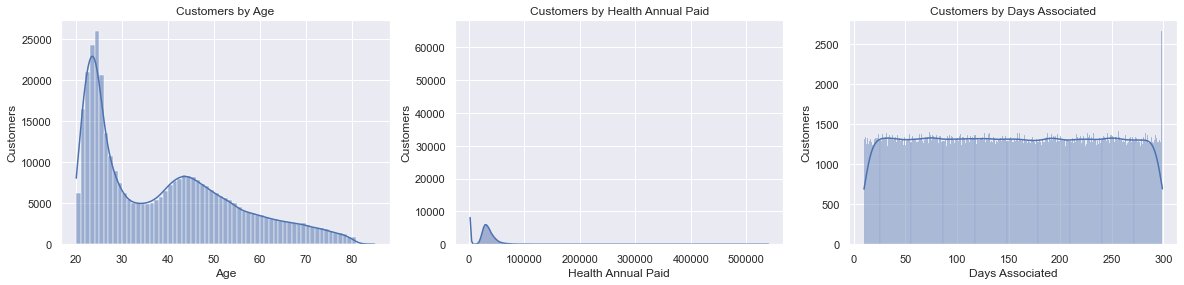

In [21]:
#Num Attributes plot
plt.figure(figsize=(20,14))

plt.subplot(3,3,1)
age_hist = sns.histplot(df1['age'], binwidth=1, kde=True);
age_hist.set_ylabel('Customers')
age_hist.set_xlabel('Age')
age_hist.set_title('Customers by Age');

plt.subplot(3,3,2)
hap_hist = sns.histplot(df1['health_annual_paid'], kde=True);
hap_hist.set_ylabel('Customers')
hap_hist.set_xlabel('Health Annual Paid')
hap_hist.set_title('Customers by Health Annual Paid');

plt.subplot(3,3,3)
da_hist = sns.histplot(df1['days_associated'], binwidth=1, kde=True);
da_hist.set_ylabel('Customers')
da_hist.set_xlabel('Days Associated')
da_hist.set_title('Customers by Days Associated');

Highlights:

- age: mean = 36y, 1 std = 15.5  -->  68% of ages are between 20,5 and 51,5 y

- health_annual_premium: very big range of 537535, high kurtosis, many extreme values.

- days_associated: very uniform, probably will not help much.

### Cathegorical Attributes


In [22]:
#variations of each column
print(f"- Distinct values:\n{cat_attributes.apply( lambda x: x.unique().shape[0] ) } \n" )
print(f"- Variations:\n{cat_attributes.apply( lambda x: x.unique() ) } " )

- Distinct values:
gender                    2
region_code              53
policy_sales_channel    155
driving_license           2
vehicle_age               3
vehicle_damage            2
vehicle_prev_insured      2
response                  2
dtype: int64 

- Variations:
gender                                                     [Male, Female]
region_code             [28, 3, 11, 41, 33, 6, 35, 50, 15, 45, 8, 36, ...
policy_sales_channel    [26, 152, 160, 124, 14, 13, 30, 156, 163, 157,...
driving_license                                                    [1, 0]
vehicle_age                               [> 2 Years, 1-2 Year, < 1 Year]
vehicle_damage                                                  [Yes, No]
vehicle_prev_insured                                               [0, 1]
response                                                           [1, 0]
dtype: object 


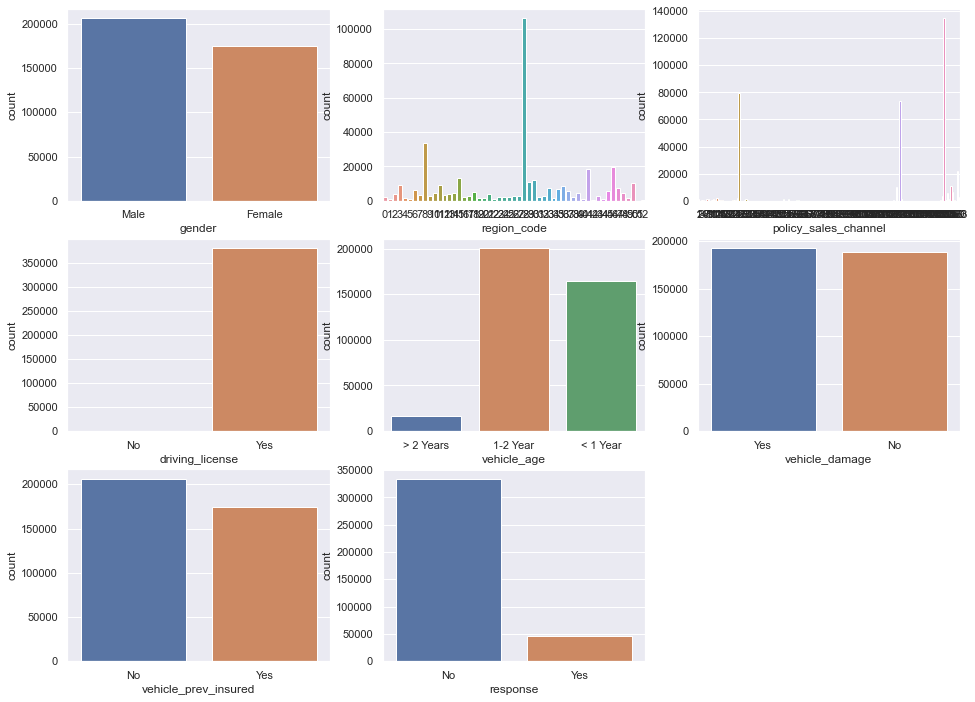

In [155]:
plt.figure(figsize=(16,12))

plt.subplot (3,3,1)
sns.countplot (x = cat_attributes['gender']);

plt.subplot (3,3,2)
sns.countplot (x = cat_attributes['region_code']);

plt.subplot (3,3,3)
sns.countplot (x = cat_attributes['policy_sales_channel']);

plt.subplot (3,3,4)
sns.countplot (x = cat_attributes['driving_license']);
plt.xticks([0,1],['No','Yes']);

plt.subplot (3,3,5)
sns.countplot (x = cat_attributes['vehicle_age']);

plt.subplot (3,3,6)
sns.countplot (x = cat_attributes['vehicle_damage']);

plt.subplot (3,3,7)
sns.countplot (x = cat_attributes['vehicle_prev_insured']);
plt.xticks([0,1],['No','Yes']);

plt.subplot (3,3,8)
sns.countplot (x = cat_attributes['response']);
plt.xticks([0,1],['No','Yes']);

In [25]:
round(cat_attributes['response'].value_counts(normalize=True) *100 ,2)

0    87.74
1    12.26
Name: response, dtype: float64

Highlights:

- Target Attribute: 12% of customers answered to be interested in a vehicle insurance.

## Test Data Extraction


In [26]:
df1.shape

(381109, 12)

In [27]:
# Test Dataset Extraction
X = df1.drop('response', axis = 1).copy()
y = df1['response'].copy()

x_train, x_test, y_train, y_test = ms.train_test_split(X, y, stratify = y, test_size = 0.20, random_state = 45)

# df2 is the new dataset, and will be used to train and validate the models
df2 = pd.concat([x_train, y_train], axis = 1)

# df_test is a separate dataset, and will be used to perfomr the final evaluation of the trained model
df_test = pd.concat([x_test, y_test], axis = 1)

In [28]:
#Check test stratify
df_test['response'].value_counts() / df_test['response'].count() 

0    0.877437
1    0.122563
Name: response, dtype: float64

In [29]:
#Check train stratify
df1['response'].value_counts() / df1['response'].count() 

0    0.877437
1    0.122563
Name: response, dtype: float64

In [30]:
x_train.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
vehicle_prev_insured    0
health_annual_paid      0
days_associated         0
dtype: int64

In [31]:
x_test.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
vehicle_prev_insured    0
health_annual_paid      0
days_associated         0
dtype: int64

In [32]:
df2.shape

(304887, 12)

In [33]:
df_test.shape

(76222, 12)

In [34]:
df_test

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,vehicle_prev_insured,health_annual_paid,days_associated,response
275163,275164,Female,24,41,152,1,< 1 Year,No,1,31696.0,62,0
228955,228956,Female,39,41,124,1,1-2 Year,Yes,0,34202.0,188,0
183986,183987,Female,25,39,152,1,< 1 Year,No,0,31140.0,200,0
272782,272783,Female,67,28,26,1,> 2 Years,Yes,0,2630.0,17,0
24900,24901,Male,23,46,152,1,< 1 Year,No,1,32159.0,149,0
...,...,...,...,...,...,...,...,...,...,...,...,...
327865,327866,Male,27,33,152,1,< 1 Year,No,1,32955.0,23,0
18930,18931,Male,49,40,124,1,> 2 Years,Yes,0,2630.0,277,0
135229,135230,Male,24,27,152,1,< 1 Year,No,0,26595.0,277,0
105049,105050,Male,22,29,152,1,< 1 Year,No,1,42844.0,140,0


In [35]:
#save datasets 
df2.to_csv(datapath+'df2_data_description_done.csv')
df_test.to_csv(datapath+'full_test_data.csv')

# Feature Engeneering

In [36]:
df2 = pd.read_csv(datapath+'df2_data_description_done.csv', index_col=0)
df2

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,vehicle_prev_insured,health_annual_paid,days_associated,response
332579,332580,Female,37,2,156,1,1-2 Year,Yes,0,2630.0,229,0
318275,318276,Female,28,33,152,1,< 1 Year,No,1,28509.0,188,0
192458,192459,Female,40,28,124,1,1-2 Year,No,0,28499.0,238,0
126596,126597,Female,25,11,152,1,< 1 Year,No,1,69023.0,264,0
318789,318790,Female,20,25,160,1,< 1 Year,No,1,2630.0,102,0
...,...,...,...,...,...,...,...,...,...,...,...,...
95668,95669,Male,24,14,152,1,< 1 Year,No,1,27831.0,256,0
67756,67757,Female,23,48,152,1,< 1 Year,Yes,0,2630.0,174,1
235038,235039,Male,21,46,160,1,< 1 Year,No,1,27712.0,16,0
157375,157376,Male,49,26,124,1,1-2 Year,Yes,0,36467.0,17,0


## Hypotheses Creation

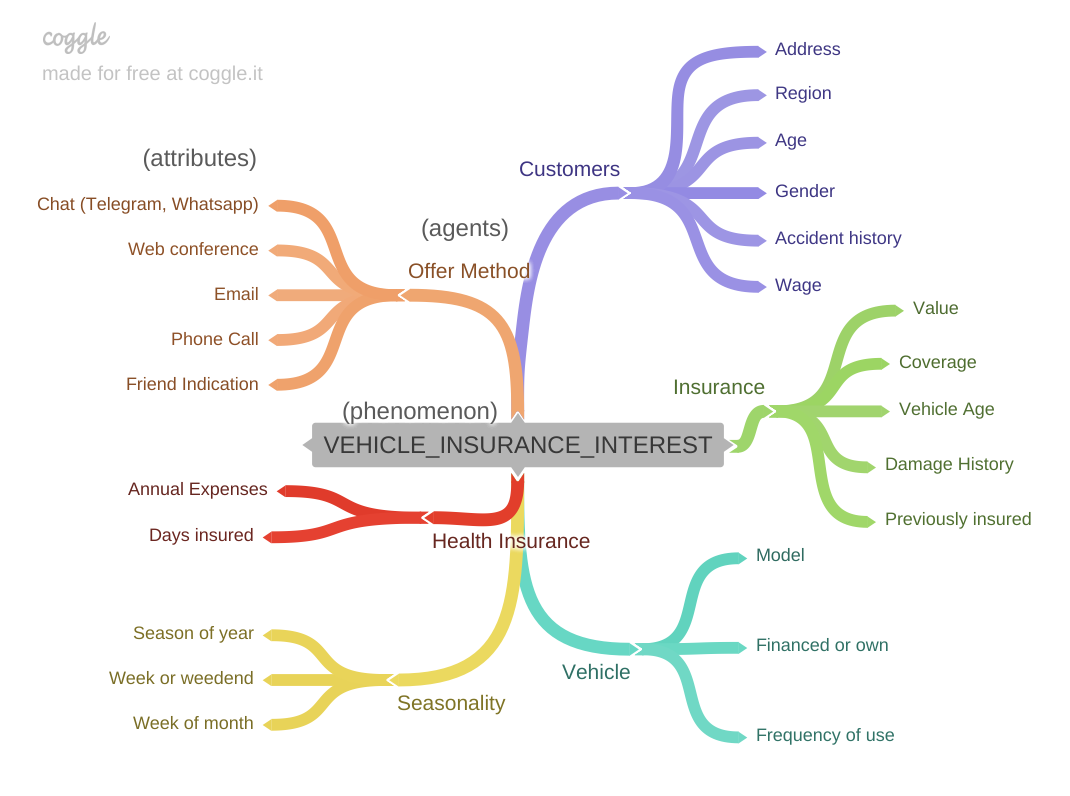

In [37]:
#hypotheses mindmap
Image( imagepath+'mindmap_hypotheses.png' )

Hypotheses Customers:
- H1) Interest is greater in customers with HIGHER AGE.
- H2) Interest is greater in FEMALE CUSTOMERS.

Hypotheses Vehicle Insurance:
- H3) Interest is greater in customers WITH MOST RECENT VEHICLE AGE.
- H4) Interest is greater in customers who HAD VEHICLE DAMAGE.
- H5) Interest is greater in Customers who HAD VEHICLE PREVIOUSLY INSURED.

Hypotheses Health Insurance:
- H6) Interest is greater in customers with HIGHER ANNUAL HEALTH EXPANSES.
- H7) Interest is greater in customers whth MORE DAYS ASSOCIATED.

Hypotheses Offer Melhods: (no data available)

Hypotheses Vehicle: (no data available)

Hypotheses Seasonality: (no data available)

*Prioritization of Hypotheses: all can be validated on first crisp cycle.

## Feature Engeneering

In [38]:
df2['vehicle_age'].value_counts()

1-2 Year     160204
< 1 Year     131877
> 2 Years     12806
Name: vehicle_age, dtype: int64

In [39]:
dict_vehicle_age = { '> 2 Years':'over_2_years', '1-2 Year':'between_1_2_years', '< 1 Year': 'below_1_year' }
df2['vehicle_age'] = df2['vehicle_age'].map(dict_vehicle_age)
df2['vehicle_age'].value_counts()

between_1_2_years    160204
below_1_year         131877
over_2_years          12806
Name: vehicle_age, dtype: int64

In [40]:
df2['vehicle_damage'].value_counts()

Yes    153936
No     150951
Name: vehicle_damage, dtype: int64

In [41]:
dict_vehicle_damage = {'Yes': 1, 'No':0}
df2['vehicle_damage'] = df2['vehicle_damage'].map(dict_vehicle_damage)
df2['vehicle_damage'].value_counts()

1    153936
0    150951
Name: vehicle_damage, dtype: int64

In [43]:
df2.to_csv(datapath+'df3_feature_engeneering_done.csv')

# Variable Filtering



In [44]:
#no business related data evaluated as needed to exclude looking at Data Description
pass

# Exploratory Data Analysis


In [104]:
df3 = pd.read_csv(datapath+'df3_feature_engeneering_done.csv', index_col=0)
df3

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,vehicle_prev_insured,health_annual_paid,days_associated,response
332579,332580,Female,37,2,156,1,between_1_2_years,1,0,2630.0,229,0
318275,318276,Female,28,33,152,1,below_1_year,0,1,28509.0,188,0
192458,192459,Female,40,28,124,1,between_1_2_years,0,0,28499.0,238,0
126596,126597,Female,25,11,152,1,below_1_year,0,1,69023.0,264,0
318789,318790,Female,20,25,160,1,below_1_year,0,1,2630.0,102,0
...,...,...,...,...,...,...,...,...,...,...,...,...
95668,95669,Male,24,14,152,1,below_1_year,0,1,27831.0,256,0
67756,67757,Female,23,48,152,1,below_1_year,1,0,2630.0,174,1
235038,235039,Male,21,46,160,1,below_1_year,0,1,27712.0,16,0
157375,157376,Male,49,26,124,1,between_1_2_years,1,0,36467.0,17,0


## Univariate Analysis - with SweetViz


In [105]:
# Generate report
report = sv.analyze(df3, target_feat='response')

# Save and show on browser
report.show_html(filepath=reportpath+'sweetviz_report.html',open_browser=True)
#Report ../reports/sweetviz_report.html was generated.

                                             |      | [  0%]   00:00 -> (? left)

Report ../reports/sweetviz_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [ ]:
# Display report on notebook
#report.show_notebook(w=None, h=None,scale=None,layout='vertical')

## Bivariate Analysis

Here, the hypotheses created previously will be validated, and Insights will be generated on the most relevant attributes of customers interested in purchasing vehicle insurance.

### H1) Interest is greater in customers with HIGHER AGE.

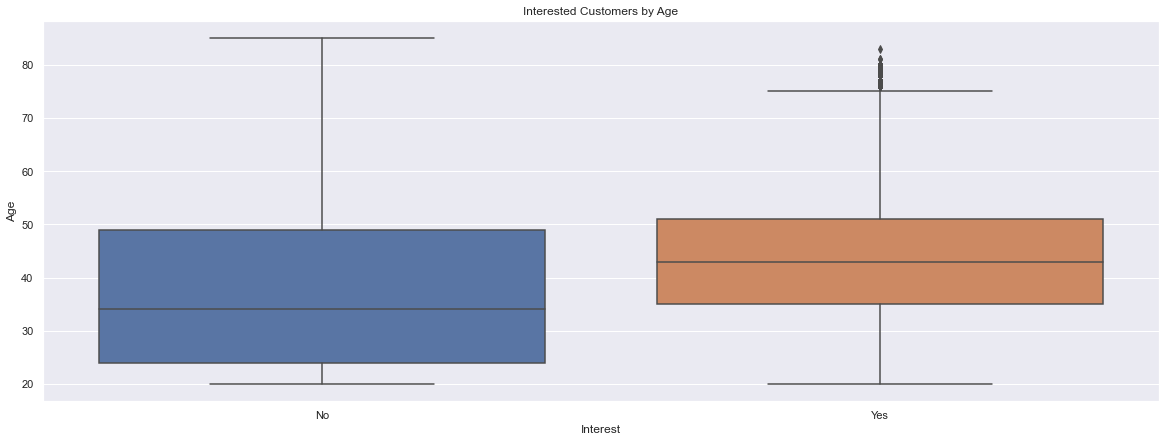

In [175]:
# Distribution of interested by age
eda_age = sns.boxplot(x = 'response', y= 'age', data = df3)
eda_age.set_xticklabels(['No', 'Yes'])
eda_age.set_ylabel('Age')
eda_age.set_xlabel('Interest')
eda_age.set_title('Interested Customers by Age');

In [123]:
#mean age of interested
df3_resp_yes = df3[df3['response']==1]
round(df3_resp_yes['age'].mean() ,1)

43.4

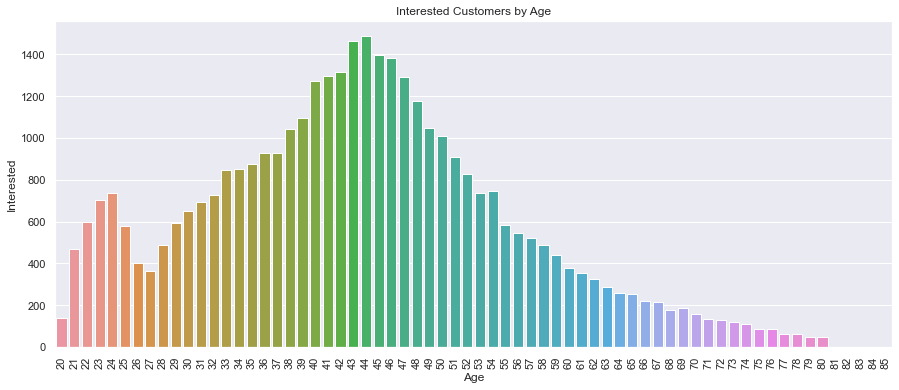

In [177]:
# Analyse just interested customers by age
plt.figure(figsize=(15,6))
aux_age2 = df3[['age', 'response']].groupby('age').sum().reset_index()
eda_age2 = sns.barplot( x='age', y='response', data=aux_age2 )
eda_age2.set_title('Interested Customers by Age')
eda_age2.set_xlabel('Age')
eda_age2.set_ylabel('Interested')
plt.xticks( rotation=90 );

False hypothesis: Customers between 40-45 years old are the most interested in vehicle insurance. 
Interest in vehicle insurance decreases between 24-27 years old and after 44 years old.

### H2) Interest is greater in FEMALE CUSTOMERS.

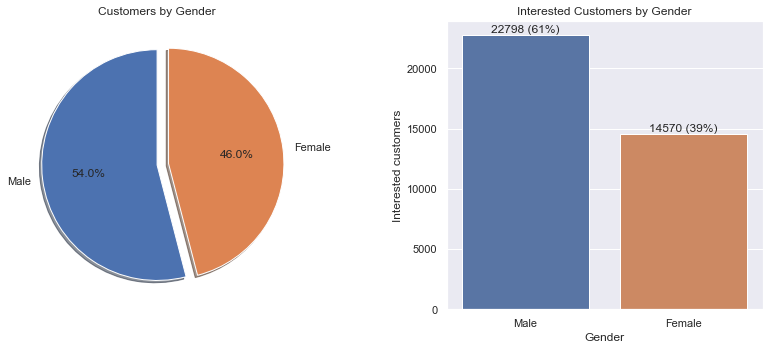

In [173]:
# Gender Interest Dashboard
#percentage of customers per gender
plt.figure(figsize=(12,6))
pie1_gen = plt.subplot (1,2,1)

pie1_gen.set_title('Customers by Gender')
perc_m, perc_f = df3['gender'].value_counts() / df3.shape[0] * 100
pie1_gen.pie([perc_m, perc_f], explode=(0, 0.1), labels=['Male', 'Female'], autopct='%1.1f%%', shadow=True, startangle=90)

#interested customers per gender
bar_gen = plt.subplot (1,2,2)

# labels
gen_true = df3.loc[df3['response'] == True]
gen_res = sns.countplot(x=gen_true['gender'],
                   order=gen_true['gender'].value_counts(ascending=False).index);
abs_values = gen_true['gender'].value_counts(ascending=False)    
rel_values = gen_true['gender'].value_counts(ascending=False, normalize=True).values * 100

lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]
gen_res.bar_label(container=gen_res.containers[0], labels=lbls);

bar_gen.set_title('Interested Customers by Gender')
bar_gen.set_xlabel('Gender')
bar_gen.set_ylabel('Interested customers')
plt.tight_layout(pad=4)

False hypothesis: 54% of customers are male, and 61% of interested customers in vehicle insurance are male. 

### H3) Interest is greater in customers WITH MOST RECENT VEHICLE AGE.

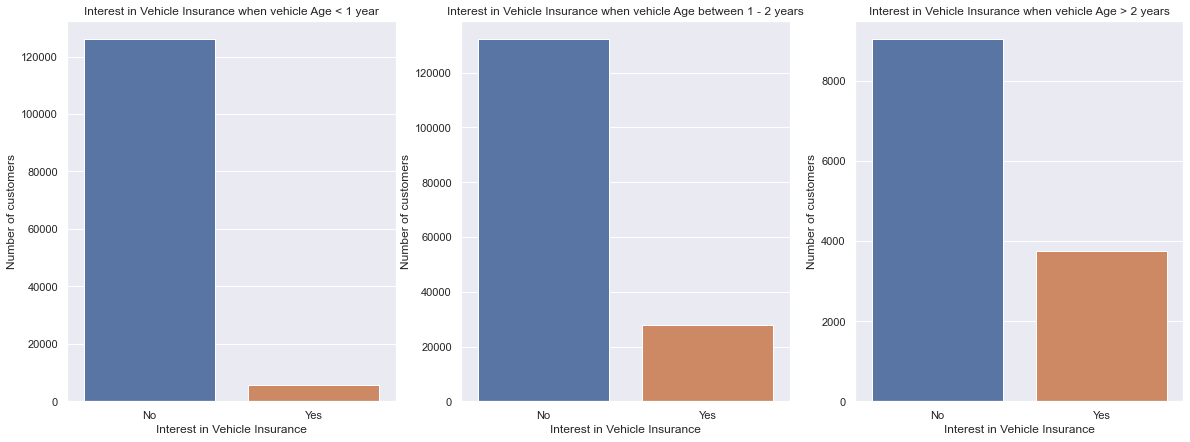

In [135]:
plt.rcParams["figure.figsize"] = (20, 7)

plt.subplot (1,3,1)
h3_df_below = df3.loc[df3['vehicle_age'] == 'below_1_year']
h3_int_below = h3_df_below[['vehicle_age', 'response']].groupby('response').count().reset_index()
fig_below_h3 = sns.barplot (x = 'response', y='vehicle_age', data=h3_int_below);
fig_below_h3.set_xlabel('Interest in Vehicle Insurance')
fig_below_h3.set_ylabel('Number of customers')
fig_below_h3.set_title('Interest in Vehicle Insurance when vehicle Age < 1 year');
fig_below_h3.set_xticklabels(['No', 'Yes']);

plt.subplot (1,3,2)
h3_df_between = df3.loc[df3['vehicle_age'] == 'between_1_2_years']
h3_int_between = h3_df_between[['vehicle_age', 'response']].groupby('response').count().reset_index()
fig_between_h3 = sns.barplot (x = 'response', y='vehicle_age', data=h3_int_between);
fig_between_h3.set_xlabel('Interest in Vehicle Insurance')
fig_between_h3.set_ylabel('Number of customers')
fig_between_h3.set_title('Interest in Vehicle Insurance when vehicle Age between 1 - 2 years');

fig_between_h3.set_xticklabels(['No', 'Yes']);

plt.subplot (1,3,3)
h3_df_over = df3.loc[df3['vehicle_age'] == 'over_2_years']
h3_int_over = h3_df_over[['vehicle_age', 'response']].groupby('response').count().reset_index()

fig_over_h3 = sns.barplot (x = 'response', y='vehicle_age', data=h3_int_over);
fig_over_h3.set_xlabel('Interest in Vehicle Insurance')
fig_over_h3.set_ylabel('Number of customers')
fig_over_h3.set_title('Interest in Vehicle Insurance when vehicle Age > 2 years');

fig_over_h3.set_xticklabels(['No', 'Yes']);

In [143]:
# 4% of customers with vehicles below 1 year are interested
h3_df_below['response'].value_counts() / h3_df_below['response'].shape[0] *100

0    95.639877
1     4.360123
Name: response, dtype: float64

In [144]:
# 17% of customers with vehicles between 1 and 2 years are interested
h3_df_between['response'].value_counts() / h3_df_between['response'].shape[0] *100

0    82.612169
1    17.387831
Name: response, dtype: float64

In [146]:
# 29% of customers with vehicles over 2 years are interested
h3_df_over['response'].value_counts() / h3_df_over['response'].shape[0] *100

0    70.623145
1    29.376855
Name: response, dtype: float64

False hypothesis: interest is greater in customers with older vehicle age:
- 29% of customers with vehicles over 2 years are interested.
- 17% of customers with vehicles between 1 and 2 years are interested.
- 4% of customers with vehicles below 1 year are interested.

### H4) Interest is greater in customers who HAD VEHICLE DAMAGE.

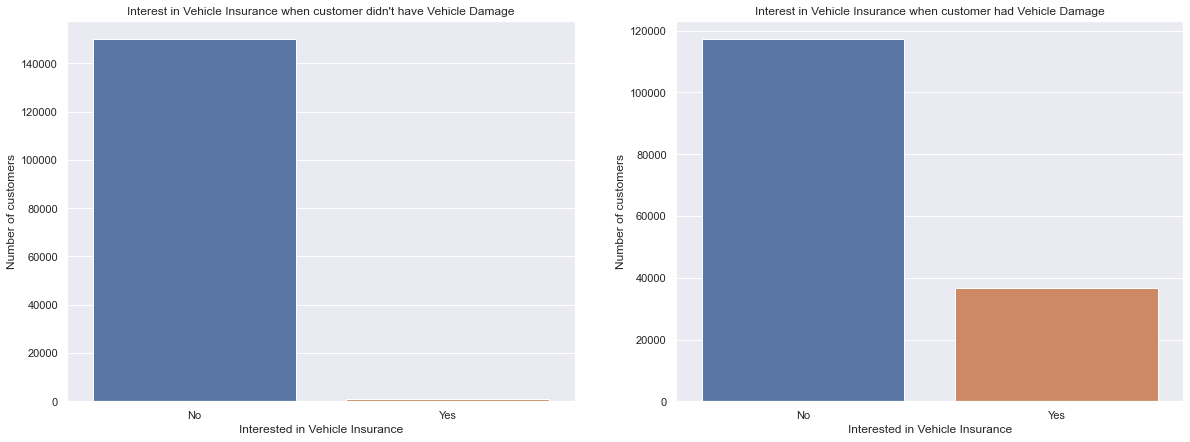

In [137]:
#vehicle_damage == 0(no): interested / not interested
plt.subplot (1,2,1)
h4_df_not_damaged = df3.loc[df3['vehicle_damage'] == 0]
h4_int_not_damaged = h4_df_not_damaged[['vehicle_damage', 'response']].groupby('response').count().reset_index()
fig_not_damaged_h4 = sns.barplot (x = 'response', y='vehicle_damage', data=h4_int_not_damaged);
fig_not_damaged_h4.set_xlabel('Interested in Vehicle Insurance')
fig_not_damaged_h4.set_ylabel('Number of customers')
fig_not_damaged_h4.set_title('Interest in Vehicle Insurance when customer didn\'t have Vehicle Damage');
fig_not_damaged_h4.set_xticklabels(['No', 'Yes']);

#vehicle_damage == 1(yes): interested / not interested
plt.subplot (1,2,2)
h4_df_damaged = df3.loc[df3['vehicle_damage'] == 1]
h4_int_damaged = h4_df_damaged[['vehicle_damage', 'response']].groupby('response').count().reset_index()
fig_damaged_h4 = sns.barplot (x = 'response', y='vehicle_damage', data=h4_int_damaged);
fig_damaged_h4.set_xlabel('Interested in Vehicle Insurance')
fig_damaged_h4.set_ylabel('Number of customers')
fig_damaged_h4.set_title('Interest in Vehicle Insurance when customer had Vehicle Damage');
fig_damaged_h4.set_xticklabels(['No', 'Yes']);

In [139]:
# Only 0.5% of customers how didn't have vehicle damage are interestet in vehicle insurance
h4_df_not_damaged['response'].value_counts() / h4_df_not_damaged.shape[0] *100

0    99.477314
1     0.522686
Name: response, dtype: float64

In [141]:
# 24% of customers how had vehicle damage are interested in vehicle insurance
h4_df_damaged['response'].value_counts() / h4_df_damaged.shape[0] *100

0    76.237527
1    23.762473
Name: response, dtype: float64

True hypothesis: 24% of customers how had vehicle damage are interested in vehicle insurance, while only 0.5% of those who didn't have vehicle damage are interestet.

### H5) Interest is greater in Customers who HAD VEHICLE PREVIOUSLY INSURED.

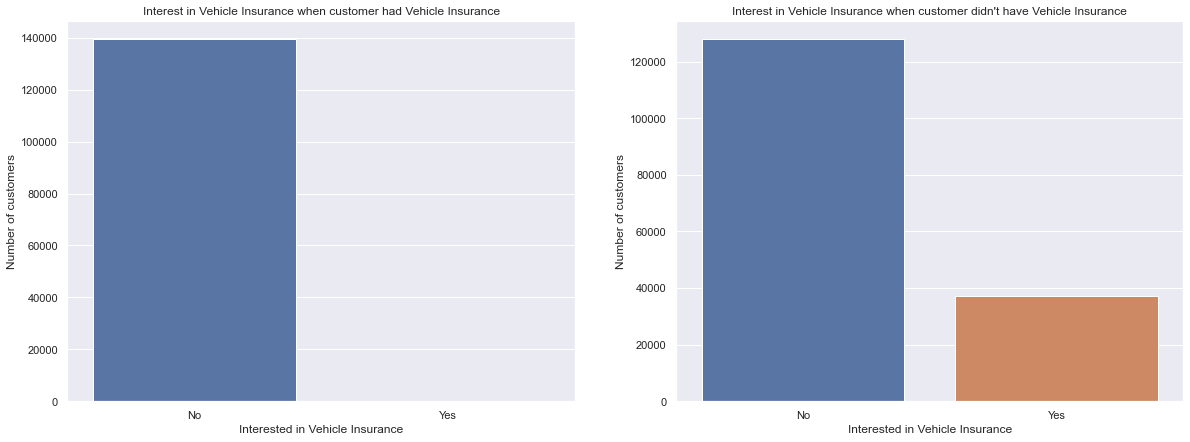

In [152]:
#vehicle_previously_insured == 1(yes): interested / not interested
plt.subplot (1,2,1)
h5_df_insured = df3.loc[df3['vehicle_prev_insured'] == 1]
h5_int_insured = h5_df_insured[['vehicle_prev_insured', 'response']].groupby('response').count().reset_index()
fig_insured_h5 = sns.barplot (x = 'response', y='vehicle_prev_insured', data=h5_int_insured);
fig_insured_h5.set_xlabel('Interested in Vehicle Insurance')
fig_insured_h5.set_ylabel('Number of customers')
fig_insured_h5.set_title('Interest in Vehicle Insurance when customer had Vehicle Insurance');
fig_insured_h5.set_xticklabels(['No', 'Yes']);

#vehicle_previously_insured == 0(no): interested / not interested
plt.subplot (1,2,2)
h5_df_not_insured = df3.loc[df3['vehicle_prev_insured'] == 0]
h5_int_not_insured = h5_df_not_insured[['vehicle_prev_insured', 'response']].groupby('response').count().reset_index()
fig_not_insured_h5 = sns.barplot (x = 'response', y='vehicle_prev_insured', data=h5_int_not_insured);
fig_not_insured_h5.set_xlabel('Interested in Vehicle Insurance')
fig_not_insured_h5.set_ylabel('Number of customers')
fig_not_insured_h5.set_title('Interest in Vehicle Insurance when customer didn\'t have Vehicle Insurance');
fig_not_insured_h5.set_xticklabels(['No', 'Yes']);

In [154]:
#1% of customers who had vehicle previously insured are interested in vehicle insurance.
h5_df_insured['response'].value_counts() / h5_df_insured['response'].shape[0] *100

0    99.903342
1     0.096658
Name: response, dtype: float64

In [155]:
#22% of customers who didn't have vehicle previously insured are interested in vehicle insurance.
h5_df_not_insured['response'].value_counts() / h5_df_not_insured['response'].shape[0] *100

0    77.464593
1    22.535407
Name: response, dtype: float64

False hypothesis: 22% of customers who didn't have vehicle previously insured are interested in vehicle insurance, while only 1% of customers who had vehicle previously insured are interested.

### H6) Interest is greater in customers with HIGHER ANNUAL HEALTH EXPANSES.

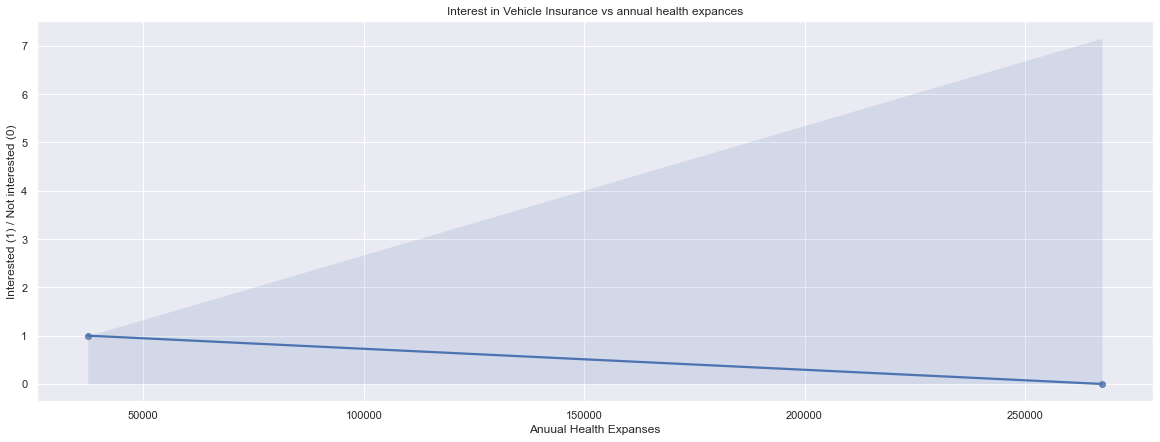

In [156]:
aux_h6 = df3[['health_annual_paid', 'response']].groupby('response').count().reset_index()
fig_h6 = sns.regplot (x= 'health_annual_paid', y='response', data=aux_h6)
fig_h6.set_xlabel('Anuual Health Expanses');
fig_h6.set_ylabel('Interested (1) / Not interested (0)')
fig_h6.set_title('Interest in Vehicle Insurance vs annual health expances');

False hypothesis: There is a decrease on interest of a vehicle insurance on higher annual health expenses.

### H7) Interest is greater in customers whth MORE DAYS ASSOCIATED.

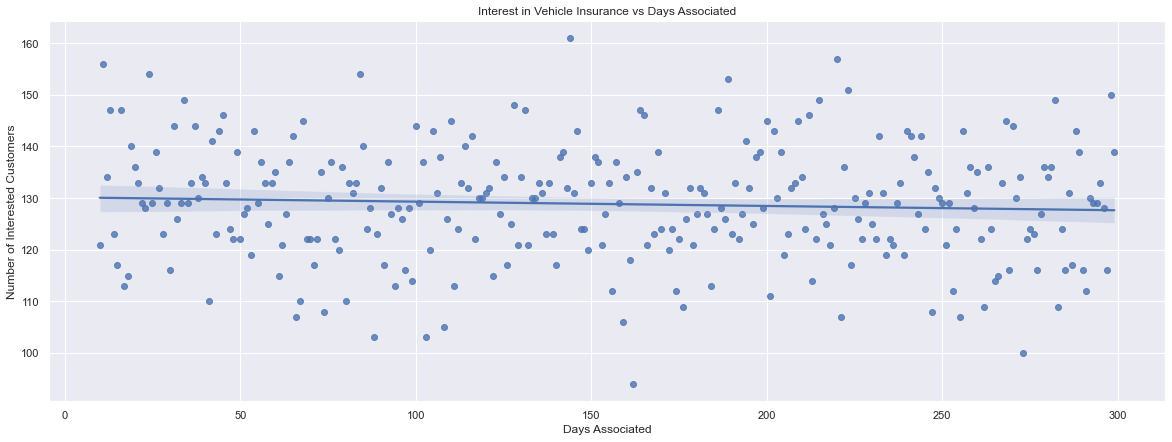

In [157]:
# get just the interested customers
aux_h7 = df3[['days_associated', 'response']].groupby('days_associated').sum().reset_index()
fig_h7 = sns.regplot (x= 'days_associated', y='response', data=aux_h7)
fig_h7.set_xlabel('Days Associated');
fig_h7.set_ylabel('Number of Interested Customers')
fig_h7.set_title('Interest in Vehicle Insurance vs Days Associated');

False hypothesis: Customers with more days of health insurance (more days associated) have a bit less interest in vehicle insurance.

## Hypothesis conclusion

Good features in a Classification Project have a natural separation. The model aims to discover a cut in space to separate two classes. "Estimated Relevance" is a preliminary analysis, to be used later in Feature Selection.

In [134]:
#hypothesis tab
hyp_tab = [['Hypoteses', 'Conclusion', 'Estimated Relevance'],
       ['H1 - Interest is greater in customers with HIGHER AGE.', 'False', 'Medium'],
       ['H2 - Interest is greater in FEMALE CUSTOMERS.', 'False', 'Low'],
       ['H3 - Interest is greater in customers WITH MOST RECENT VEHICLE AGE.', 'False', 'High'],
       ['H4 - Interest is greater in customers who HAD VEHICLE DAMAGE.', 'True', 'High'],
       ['H5 - Interest is greater in Customers who HAD VEHICLE PREVIOUSLY INSURED.', 'False', 'High'],
       ['H6 - Interest is greater in customers with HIGHER ANNUAL HEALTH EXPANSES.', 'False', 'Low'],
       ['H7 - Interest is greater in customers whth MORE DAYS ASSOCIATED', 'False', 'Low'],
      ]
print(tabulate(hyp_tab, headers='firstrow', stralign='left', tablefmt='rst'))

=========================================================================  ============  =====================
Hypoteses                                                                  Conclusion    Estimated Relevance
=========================================================================  ============  =====================
H1 - Interest is greater in customers with HIGHER AGE.                     False         Medium
H2 - Interest is greater in FEMALE CUSTOMERS.                              False         Low
H3 - Interest is greater in customers WITH MOST RECENT VEHICLE AGE.        False         High
H4 - Interest is greater in customers who HAD VEHICLE DAMAGE.              True          High
H5 - Interest is greater in Customers who HAD VEHICLE PREVIOUSLY INSURED.  False         High
H6 - Interest is greater in customers with HIGHER ANNUAL HEALTH EXPANSES.  False         Low
H7 - Interest is greater in customers whth MORE DAYS ASSOCIATED            False         Low
============

# Data Preparation


In [97]:
df4 = pd.read_csv(datapath+'df3_feature_engeneering_done.csv', index_col=0)
df4

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,vehicle_prev_insured,health_annual_paid,days_associated,response
332579,332580,Female,37,2,156,1,between_1_2_years,1,0,2630.0,229,0
318275,318276,Female,28,33,152,1,below_1_year,0,1,28509.0,188,0
192458,192459,Female,40,28,124,1,between_1_2_years,0,0,28499.0,238,0
126596,126597,Female,25,11,152,1,below_1_year,0,1,69023.0,264,0
318789,318790,Female,20,25,160,1,below_1_year,0,1,2630.0,102,0
...,...,...,...,...,...,...,...,...,...,...,...,...
95668,95669,Male,24,14,152,1,below_1_year,0,1,27831.0,256,0
67756,67757,Female,23,48,152,1,below_1_year,1,0,2630.0,174,1
235038,235039,Male,21,46,160,1,below_1_year,0,1,27712.0,16,0
157375,157376,Male,49,26,124,1,between_1_2_years,1,0,36467.0,17,0


## Standardization

For numeric vars with normal distribution.

- health_annual_paid has normal distribution, as filtered previously (health_annual_paid < 80000).

Values outside this range could be removed if considered outliers, but it is not clear if they are.

Let's standardise them in 1st Crisp cycle then.

In [82]:
#health_annual_paid -> StandardScaler
ss = pp.StandardScaler()
df4['health_annual_paid'] = ss.fit_transform( df4[['health_annual_paid']].values )
pickle.dump (ss, open (featurepath+'health_annual_paid_scaler.pkl', 'wb') )

## Rescaling


For numeric vars with NOT normal distribution.

In [52]:
# MinMaxScaler (few outliers)
mms_age = pp.MinMaxScaler()
mms_days_assoc = pp.MinMaxScaler()

#age
df4['age'] = mms_age.fit_transform( df4[['age']].values )
pickle.dump (mms_age, open (featurepath+'age_scaler.pkl', 'wb') )

#days_associated
df4['days_associated'] = mms_days_assoc.fit_transform( df4[['days_associated']].values )
pickle.dump (mms_days_assoc, open (featurepath+'days_assoc_scaler.pkl', 'wb') )

## Encoding

Transform categorical variables into numeric.

Some variables are aleready encoded (0 and 1): driving_license, vehicle_prev_insured, vehicle_damage

In [53]:
#gender: one hot encoder / target encoder (let's use target encoding)
gender_target_encoder = df4.groupby('gender')['response'].mean()
df4.loc[:,'gender'] = df4['gender'].map(gender_target_encoder)
pickle.dump (gender_target_encoder, open (featurepath+'gender_target_encoder.pkl', 'wb') )

#region_code: requency encoding / target encoding / weighted target encoding  (let's use target encoding)
region_code_target_encoder = df4.groupby('region_code')['response'].mean()
df4.loc[:,'region_code'] = df4['region_code'].map(region_code_target_encoder)
pickle.dump (region_code_target_encoder, open (featurepath+'region_code_target_encoder.pkl', 'wb') )

#vehicle_age: one hot encoding / Label Encoding / frequency encoding (let's use one hot encoding)
df4 = pd.get_dummies( df4, prefix='vehicle_age', columns=['vehicle_age'] )

#policy_sales_channel: frequency encoding / target encoding (let's use frequency encoding)
policy_sales_freq_encoder = df4.groupby('policy_sales_channel').size() / len (df4)
df4.loc[:,'policy_sales_channel'] = df4['policy_sales_channel'].map(policy_sales_freq_encoder)
pickle.dump (policy_sales_freq_encoder, open (featurepath+'policy_sales_freq_encoder.pkl', 'wb') )

In [54]:
# Prepared Training dataset:
df4

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,vehicle_prev_insured,health_annual_paid,days_associated,response,vehicle_age_below_1_year,vehicle_age_between_1_2_years,vehicle_age_over_2_years
332579,332580,0.103991,0.261538,0.070701,0.028076,1,1,0,-1.625561,0.757785,0,0,1,0
318275,318276,0.103991,0.123077,0.101226,0.353482,1,0,1,-0.119045,0.615917,0,1,0,0
192458,192459,0.103991,0.307692,0.186638,0.193626,1,0,0,-0.119627,0.788927,0,0,1,0
126596,126597,0.103991,0.076923,0.116003,0.353482,1,0,1,2.239430,0.878893,0,1,0,0
318789,318790,0.103991,0.000000,0.041289,0.057067,1,0,1,-1.625561,0.318339,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95668,95669,0.138355,0.061538,0.090812,0.353482,1,0,1,-0.158514,0.851211,0,1,0,0
67756,67757,0.103991,0.046154,0.101256,0.353482,1,1,0,-1.625561,0.567474,1,1,0,0
235038,235039,0.138355,0.015385,0.103851,0.057067,1,0,1,-0.165441,0.020761,0,1,0,0
157375,157376,0.138355,0.446154,0.071463,0.193626,1,1,0,0.344221,0.024221,0,0,1,0


## Test Preparation

Replicate the transformation done in Training(df4) to x_test dataset.

In [55]:
#load x_test and y_test from test data.
#x_test = pd.read_csv(datapath+'full_test_data.csv.csv', index_col=0)
x_test = df_test
y_test = x_test['response']
x_test = x_test.drop('response', axis=1)
x_test

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,vehicle_prev_insured,health_annual_paid,days_associated
275163,275164,Female,24,41,152,1,< 1 Year,No,1,31696.0,62
228955,228956,Female,39,41,124,1,1-2 Year,Yes,0,34202.0,188
183986,183987,Female,25,39,152,1,< 1 Year,No,0,31140.0,200
272782,272783,Female,67,28,26,1,> 2 Years,Yes,0,2630.0,17
24900,24901,Male,23,46,152,1,< 1 Year,No,1,32159.0,149
...,...,...,...,...,...,...,...,...,...,...,...
327865,327866,Male,27,33,152,1,< 1 Year,No,1,32955.0,23
18930,18931,Male,49,40,124,1,> 2 Years,Yes,0,2630.0,277
135229,135230,Male,24,27,152,1,< 1 Year,No,0,26595.0,277
105049,105050,Male,22,29,152,1,< 1 Year,No,1,42844.0,140


In [56]:
x_test

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,vehicle_prev_insured,health_annual_paid,days_associated
275163,275164,Female,24,41,152,1,< 1 Year,No,1,31696.0,62
228955,228956,Female,39,41,124,1,1-2 Year,Yes,0,34202.0,188
183986,183987,Female,25,39,152,1,< 1 Year,No,0,31140.0,200
272782,272783,Female,67,28,26,1,> 2 Years,Yes,0,2630.0,17
24900,24901,Male,23,46,152,1,< 1 Year,No,1,32159.0,149
...,...,...,...,...,...,...,...,...,...,...,...
327865,327866,Male,27,33,152,1,< 1 Year,No,1,32955.0,23
18930,18931,Male,49,40,124,1,> 2 Years,Yes,0,2630.0,277
135229,135230,Male,24,27,152,1,< 1 Year,No,0,26595.0,277
105049,105050,Male,22,29,152,1,< 1 Year,No,1,42844.0,140


In [57]:
df_test

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,vehicle_prev_insured,health_annual_paid,days_associated,response
275163,275164,Female,24,41,152,1,< 1 Year,No,1,31696.0,62,0
228955,228956,Female,39,41,124,1,1-2 Year,Yes,0,34202.0,188,0
183986,183987,Female,25,39,152,1,< 1 Year,No,0,31140.0,200,0
272782,272783,Female,67,28,26,1,> 2 Years,Yes,0,2630.0,17,0
24900,24901,Male,23,46,152,1,< 1 Year,No,1,32159.0,149,0
...,...,...,...,...,...,...,...,...,...,...,...,...
327865,327866,Male,27,33,152,1,< 1 Year,No,1,32955.0,23,0
18930,18931,Male,49,40,124,1,> 2 Years,Yes,0,2630.0,277,0
135229,135230,Male,24,27,152,1,< 1 Year,No,0,26595.0,277,0
105049,105050,Male,22,29,152,1,< 1 Year,No,1,42844.0,140,0


In [58]:
y_test

275163    0
228955    0
183986    0
272782    0
24900     0
         ..
327865    0
18930     0
135229    0
105049    0
187934    0
Name: response, Length: 76222, dtype: int64

In [59]:
# ----- Feature Engeneering ----- 
#vehicle_damage
x_test['vehicle_damage'] = x_test['vehicle_damage'].map(dict_vehicle_damage)
#vehicle_age
x_test['vehicle_age'] = x_test['vehicle_age'].map(dict_vehicle_age)

# ----- Data Preparation - Standardization ----- 
#health_annual_paid: StandardScaler
x_test['health_annual_paid'] = ss.transform(x_test[['health_annual_paid']].values)
    #If we used fit_transform() on our test data too, we would compute a new mean and variance, that is a new scale for each feature, and would let our model learn about our test data too. Using transform() we use the same mean and variance as it is calculated from our training data to transform our test data.

# ----- Data Preparation - Rescaling ----- 
#age: MinMaxScaler
x_test['age'] = mms_age.transform( x_test[['age']].values )
#days_associated: MinMaxScaler
x_test['days_associated'] = mms_days_assoc.transform( x_test[['days_associated']].values )

# ----- Data Preparation - Encoding ----- 
#vehicle_age: one hot encoding 
x_test = pd.get_dummies( x_test, prefix='vehicle_age', columns=['vehicle_age'] ) 
#gender: target encoding
x_test.loc[:,'gender'] = x_test.loc[:,'gender'].map(gender_target_encoder)
#region_code: target encoding
x_test.loc[:,'region_code'] = x_test.loc[:,'region_code'].map(region_code_target_encoder)
#policy_sales_channel: frequency encoding
x_test.loc[:,'policy_sales_channel'] = x_test['policy_sales_channel'].map(policy_sales_freq_encoder)  

### Check Test

Check if x_test dataset is now like Training (df4). Exception: response var.

In [60]:
x_test

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,vehicle_prev_insured,health_annual_paid,days_associated,vehicle_age_below_1_year,vehicle_age_between_1_2_years,vehicle_age_over_2_years
275163,275164,0.103991,0.061538,0.122890,0.353482,1,0,1,31696.0,0.179931,1,0,0
228955,228956,0.103991,0.292308,0.122890,0.193626,1,1,0,34202.0,0.615917,0,1,0
183986,183987,0.103991,0.076923,0.123620,0.353482,1,0,0,31140.0,0.657439,1,0,0
272782,272783,0.103991,0.723077,0.186638,0.209901,1,1,0,2630.0,0.024221,0,0,1
24900,24901,0.138355,0.046154,0.103851,0.353482,1,0,1,32159.0,0.480969,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
327865,327866,0.138355,0.107692,0.101226,0.353482,1,0,1,32955.0,0.044983,1,0,0
18930,18931,0.138355,0.446154,0.120316,0.193626,1,1,0,2630.0,0.923875,0,0,1
135229,135230,0.138355,0.061538,0.073861,0.353482,1,0,0,26595.0,0.923875,1,0,0
105049,105050,0.138355,0.030769,0.123155,0.353482,1,0,1,42844.0,0.449827,1,0,0


In [61]:
df4

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,vehicle_prev_insured,health_annual_paid,days_associated,response,vehicle_age_below_1_year,vehicle_age_between_1_2_years,vehicle_age_over_2_years
332579,332580,0.103991,0.261538,0.070701,0.028076,1,1,0,-1.625561,0.757785,0,0,1,0
318275,318276,0.103991,0.123077,0.101226,0.353482,1,0,1,-0.119045,0.615917,0,1,0,0
192458,192459,0.103991,0.307692,0.186638,0.193626,1,0,0,-0.119627,0.788927,0,0,1,0
126596,126597,0.103991,0.076923,0.116003,0.353482,1,0,1,2.239430,0.878893,0,1,0,0
318789,318790,0.103991,0.000000,0.041289,0.057067,1,0,1,-1.625561,0.318339,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95668,95669,0.138355,0.061538,0.090812,0.353482,1,0,1,-0.158514,0.851211,0,1,0,0
67756,67757,0.103991,0.046154,0.101256,0.353482,1,1,0,-1.625561,0.567474,1,1,0,0
235038,235039,0.138355,0.015385,0.103851,0.057067,1,0,1,-0.165441,0.020761,0,1,0,0
157375,157376,0.138355,0.446154,0.071463,0.193626,1,1,0,0.344221,0.024221,0,0,1,0


In [62]:
print('Check NA:')
x_test.isna().sum()

Check NA:


id                               0
gender                           0
age                              0
region_code                      0
policy_sales_channel             2
driving_license                  0
vehicle_damage                   0
vehicle_prev_insured             0
health_annual_paid               0
days_associated                  0
vehicle_age_below_1_year         0
vehicle_age_between_1_2_years    0
vehicle_age_over_2_years         0
dtype: int64

In [63]:
# Check the rows with NaN
x_test.loc[x_test['policy_sales_channel'].isna()]

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,vehicle_prev_insured,health_annual_paid,days_associated,vehicle_age_below_1_year,vehicle_age_between_1_2_years,vehicle_age_over_2_years
228805,228806,0.138355,0.384615,0.186638,NaN,1,1,0,57744.0,0.923875,0,1,0
24016,24017,0.103991,0.384615,0.186638,NaN,1,1,0,47383.0,0.737024,0,1,0


In [64]:
# Remove these indexes on x_test
x_test = x_test.drop(index = [228805,24016] )
x_test.shape

(76220, 13)

In [65]:
# Remove these indexes on y_test
y_test = y_test.drop(index = [228805,24016] )
y_test.shape

(76220,)

In [66]:
print('Check NA:')
x_test.isna().sum()

Check NA:


id                               0
gender                           0
age                              0
region_code                      0
policy_sales_channel             0
driving_license                  0
vehicle_damage                   0
vehicle_prev_insured             0
health_annual_paid               0
days_associated                  0
vehicle_age_below_1_year         0
vehicle_age_between_1_2_years    0
vehicle_age_over_2_years         0
dtype: int64

All set with x_test dataset!

In [ ]:
#Export Training
df4.to_csv(datapath+'df4_data_prep_done.csv') #contains x_train + y_train
#Export Test
x_test.to_csv(datapath+'x_test.csv') #x_test
y_test.to_csv(datapath+'y_test.csv') #y_test

In [ ]:
#não é útil o x_test sem id! mantive pra entender onde era necessário.. posso carregar ele do x_test.csv que tem o id!

#drop id, won't be used by models, but will be usefull in future, so already exported.
# x_test = x_test.drop('id', axis=1)
# x_test

# Feature Selection

In [156]:
df5 = pd.read_csv(datapath+'df4_data_prep_done.csv', index_col=0)
df5

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,vehicle_prev_insured,health_annual_paid,days_associated,response,vehicle_age_below_1_year,vehicle_age_between_1_2_years,vehicle_age_over_2_years
332579,332580,0.103991,0.261538,0.070701,0.028076,1,1,0,-1.625561,0.757785,0,0,1,0
318275,318276,0.103991,0.123077,0.101226,0.353482,1,0,1,-0.119045,0.615917,0,1,0,0
192458,192459,0.103991,0.307692,0.186638,0.193626,1,0,0,-0.119627,0.788927,0,0,1,0
126596,126597,0.103991,0.076923,0.116003,0.353482,1,0,1,2.239430,0.878893,0,1,0,0
318789,318790,0.103991,0.000000,0.041289,0.057067,1,0,1,-1.625561,0.318339,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95668,95669,0.138355,0.061538,0.090812,0.353482,1,0,1,-0.158514,0.851211,0,1,0,0
67756,67757,0.103991,0.046154,0.101256,0.353482,1,1,0,-1.625561,0.567474,1,1,0,0
235038,235039,0.138355,0.015385,0.103851,0.057067,1,0,1,-0.165441,0.020761,0,1,0,0
157375,157376,0.138355,0.446154,0.071463,0.193626,1,1,0,0.344221,0.024221,0,0,1,0


## Validation Split


Perform a new data split, now extracting Validation from Training (df5).

In [ ]:
df5

In [157]:
X = df5.drop(['response', 'id'], axis = 1).copy() # 304887 rows × 12 columns
y = df5['response'].copy() #Length: 304887

#Split Train into Val:
x_train, x_val, y_train, y_val = ms.train_test_split(X, y, stratify = y, test_size=0.10, random_state = 45)

In [158]:
#check split
print('x_train -> ',x_train.shape)
print('y_train -> ',y_train.shape)
print('x_val -> ',x_val.shape)
print('y_val -> ',y_val.shape)

x_train ->  (274398, 12)
y_train ->  (274398,)
x_val ->  (30489, 12)
y_val ->  (30489,)


## Extra Trees

Lets use Extra Trees to find features importance. Could be a Botura, RandomForest, XGBoost, etc

In [159]:
# model definition
extra_trees = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

In [160]:
# data preparation
x_train_n = x_train # (274398 rows × 12 columns)
y_train_n = y_train.values #(274398 rows)
extra_trees.fit( x_train_n, y_train_n )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature Ranking:
                         feature  importance
0                days_associated    0.272126
0             health_annual_paid    0.242555
0                            age    0.164634
0                    region_code    0.107642
0                 vehicle_damage    0.068254
0           policy_sales_channel    0.060123
0           vehicle_prev_insured    0.055809
0       vehicle_age_below_1_year    0.014694
0  vehicle_age_between_1_2_years    0.006395
0                         gender    0.004929
0       vehicle_age_over_2_years    0.002318
0                driving_license    0.000521


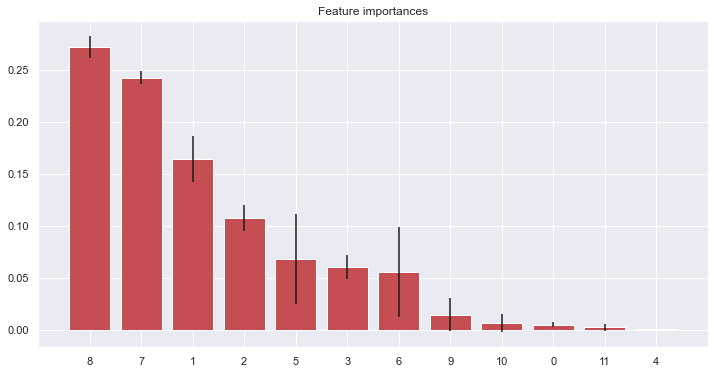

In [161]:
importances = extra_trees.feature_importances_
std = np.std( [tree.feature_importances_ for tree in extra_trees.estimators_], axis=0 )
indices = np.argsort(importances)[::-1] #trees importance ordered by greater value

# Print feature ranking
print('Feature Ranking:')
df_imp = pd.DataFrame()
for i, j in zip( x_train_n, extra_trees.feature_importances_ ):
    aux = pd.DataFrame( {'feature':i , 'importance': j}, index=[0] )
    df_imp = pd.concat( [df_imp, aux], axis=0 )
    
print(df_imp.sort_values('importance', ascending=False) )

# Plot the imputity-based feature importances of the forest
plt.figure()
plt.title('Feature importances')
plt.bar( range(x_train_n.shape[1]), importances[indices], color='r', yerr=std[indices], align='center' )
plt.xticks( range(x_train_n.shape[1]), indices )
plt.xlim( [-1, x_train_n.shape[1]] )
plt.show()

Let's consider now Extra Trees vs EDA Analisys:

Features with relevance estimated on EDA:

| Variable             | Estimated Relevance   |
|:---------------------|:----------------------|
| vehicle_damage       | Very High             |
| vehicle_prev_insured | Very High             |
| vehicle_age          | High                  |
| policy_sales_channel | High                  |
| age                  | Medium                |
| gender               | Low                   |
| region_code          | Low                   |
| driving_license      | Low                   |
| health_annual_paid   | Low                   |
| days_associated      | None                  |

The most relevant feature of ET (days_associated) with 27% of relevance, was the worst feature on my EDA.

On the other hand, vehicle_age looks irreleant (1% to  vehicle_age_below_1_year ), and on EDA was High.

Lets Select the top 7 most important features from E.T. on this Crisp cycle, and check model's performance with them. 

In [162]:
cols_selected = ['days_associated','health_annual_paid','age','region_code',
                 'vehicle_damage','policy_sales_channel', 'vehicle_prev_insured']

#new x data, only with cols selected:
x_train = x_train[ cols_selected ]
x_val = x_val[ cols_selected ]

In [164]:
x_train

,days_associated,health_annual_paid,age,region_code,vehicle_damage,policy_sales_channel,vehicle_prev_insured
338662,0.792388,-0.035741,0.030769,0.116003,0,0.353482,1
255559,0.543253,0.537840,0.030769,0.095707,0,0.353482,1
186485,0.391003,-0.377980,0.046154,0.122368,0,0.209901,0
192350,0.069204,0.074749,0.046154,0.186638,0,0.057067,1
59040,0.709343,-0.474091,0.061538,0.122368,0,0.353482,1
...,...,...,...,...,...,...,...
328338,0.972318,0.058857,0.523077,0.071869,1,0.209901,0
359877,0.152249,0.007163,0.030769,0.186638,1,0.353482,0
212867,0.889273,0.369718,0.230769,0.091418,1,0.193626,0
245992,0.688581,0.249740,0.476923,0.186638,1,0.193626,0


In [163]:
y_val

357106    0
124943    0
352930    0
16739     0
301457    1
         ..
106893    1
216302    0
255611    0
305876    0
51464     0
Name: response, Length: 30489, dtype: int64

In [ ]:
#Export Training w/ sel features
x_train.to_csv(datapath+'x_train.csv')
y_train.to_csv(datapath+'y_train.csv')

#Export Validation w/ sel features
x_val.to_csv(datapath+'x_val.csv')
y_val.to_csv(datapath+'y_val.csv')